In [1]:
import warnings 
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import pylab as pl

from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import shap

The motivation of the notebook:

A relevant industrial real estate developer in the Middle east have to launch products in new areas of the country where there is a lack of market for the products that are to be launch. This company is an arm of the Ministry of Industry and seeks to foster the diversification of the manufacturing base away from the oil. Therefore, the products to be launched are Industrial real estate plots, industrial and retail buildings, warehouses and other ancillary facilities. There are many features of the products that has to be decided, as location, sizes, building features that might be more demanded that others. 

As there is few information about the demand in certain areas, the industrial districts are projected with great flexibility to allow redesign and re-work of the products. This leads to obsolescence of the product, longer time to market, all in all overall budget overruns and wasted resources. 

One possible idea to try mitigate this problem, would be to cluster the industrial development according to certain characteristics and try to benefit of the experience of older developments, and use already successful features in a new similar development. This approach is empirically done but as the company grows the amount of data available also grows and maybe there would be an opportunity to better structure the process.  

The identification of features relevant to certain products could also support in the other main problem that the company faces, which is pricing the assets and price transparency. If an appropriate model could assign value to a given feature it could help support the price strategy and bring more transparency to the process. The management team at the company is skeptical about this process, and it was requested to document better. I had to show how this process would be done and what could be learned from it, as if the current data does not allow them to be used as some preprocessing would be needed as well as the notion of value will need to be studied to see how it could be assigned. The prices are subsidized and there is not actual market as mentioned before. It was requested to try this approach in an existing data set to see what could be learned. 

The dataset: 

The selected data set from Boston has already some attributes that looks very interesting for this exercise like ZN proportion of residential land zoned for lots over 25,000 sq.ft; INDUS proportion of non-retail business acres per town; NOX nitric oxides concentration (parts per 10 million); RAD index of accessibility to radial highways; DIS weighted distances to five Boston employment centers. Those are some attributes very similar to some of the current question marks the company has. Understanding how those and other attributes might influence real estate market price would be interesting before embarking in a more complex task of prepare the own company data.

The process:

1- Understanding of the data set.
2- Clustering with various methods to decide what is best
3- Fit an Ensemble of Random Forest, best prediction of the MEDV (Median value of owner-occupied homes in $1000's), was not per se the most relevant task rather the understanding of the features impacting this value, but in any case, Random Forest ensemble could lead to a best prediction at the time that allows a relevant features analysis that was the main purpose of this notebook.
4. The ERFRegressor was used in the entire data and the features analyzed and then the same analysis was done for each of the three clusters.

In the last phase the shap value was computed so that it can been seen in feature impact on the price and how it shifts. Examples were provided for each of the cases. 

DATA SET LOADING AND UNDERSTANDING

In [2]:
df = pd.read_csv("data.csv")
data = df

In [3]:
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

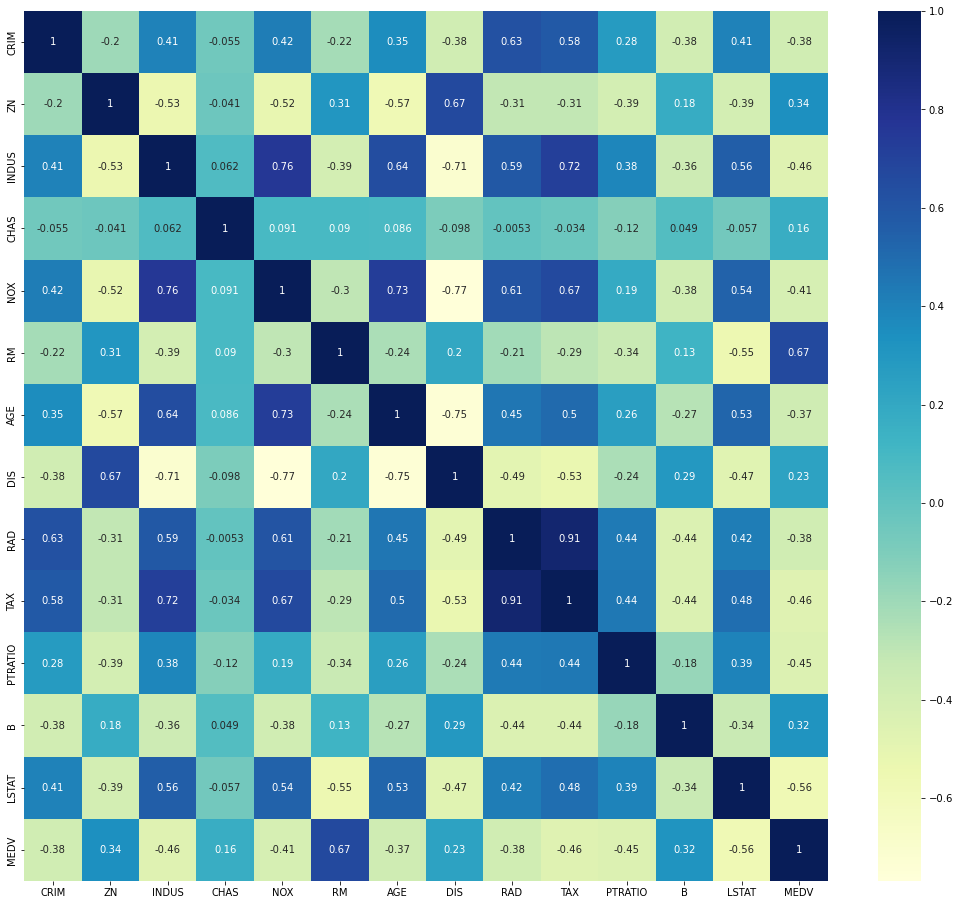

In [4]:
plt.figure(figsize=(18,16))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlGnBu)
plt.show()

In [5]:
corr_matrix = df.corr()
corr_matrix['MEDV'].sort_values(ascending=True)

LSTAT     -0.562960
INDUS     -0.463269
TAX       -0.459274
PTRATIO   -0.447464
NOX       -0.411486
CRIM      -0.380072
RAD       -0.379016
AGE       -0.368203
CHAS       0.164782
DIS        0.233469
B          0.317941
ZN         0.339767
RM         0.667695
MEDV       1.000000
Name: MEDV, dtype: float64

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     511 non-null    float64
 1   ZN       511 non-null    float64
 2   INDUS    511 non-null    float64
 3   CHAS     511 non-null    int64  
 4   NOX      511 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      511 non-null    float64
 7   DIS      511 non-null    float64
 8   RAD      511 non-null    int64  
 9   TAX      511 non-null    int64  
 10  PTRATIO  511 non-null    float64
 11  B        511 non-null    float64
 12  LSTAT    511 non-null    float64
 13  MEDV     511 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 56.0 KB


CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  506.000000   
mean     3.584139   11.252446   11.151096    0.068493    0.554757    6.287589   
std      8.564433   23.234838    6.828175    0.252838    0.115310    0.703802   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082325    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.261690    0.000000    9.690000    0.000000    0.538000    6.209000   
75%      3.621175   12.500000   18.100000    0.000000    0.624000    6.629750   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean    68.616243    3.783876    9.485323  407.440313   18.500000  356.600900   
std     28.099130    2.098631    8.688469  167.903532    2.200348   90.882679   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.050000    2.100350    4.000000  279.500000   17.400000  374.710000   
50%     77.300000    3.152300    5.000000  330.000000   19.100000  391.340000   
75%     94.050000    5.118000   24.000000  666.000000   20.200000  396.210000   
max    100.000000   12.126500   24.000000  711.000000   23.000000  396.900000   

            LSTAT        MEDV  
count  511.000000  511.000000  
mean    12.879550   22.682192  
std      7.797416    9.484262  
min      1.730000    5.000000  
25%      7.065000   17.050000  
50%     11.450000   21.200000  
75%     17.105000   25.000000  
max     76.000000   67.000000

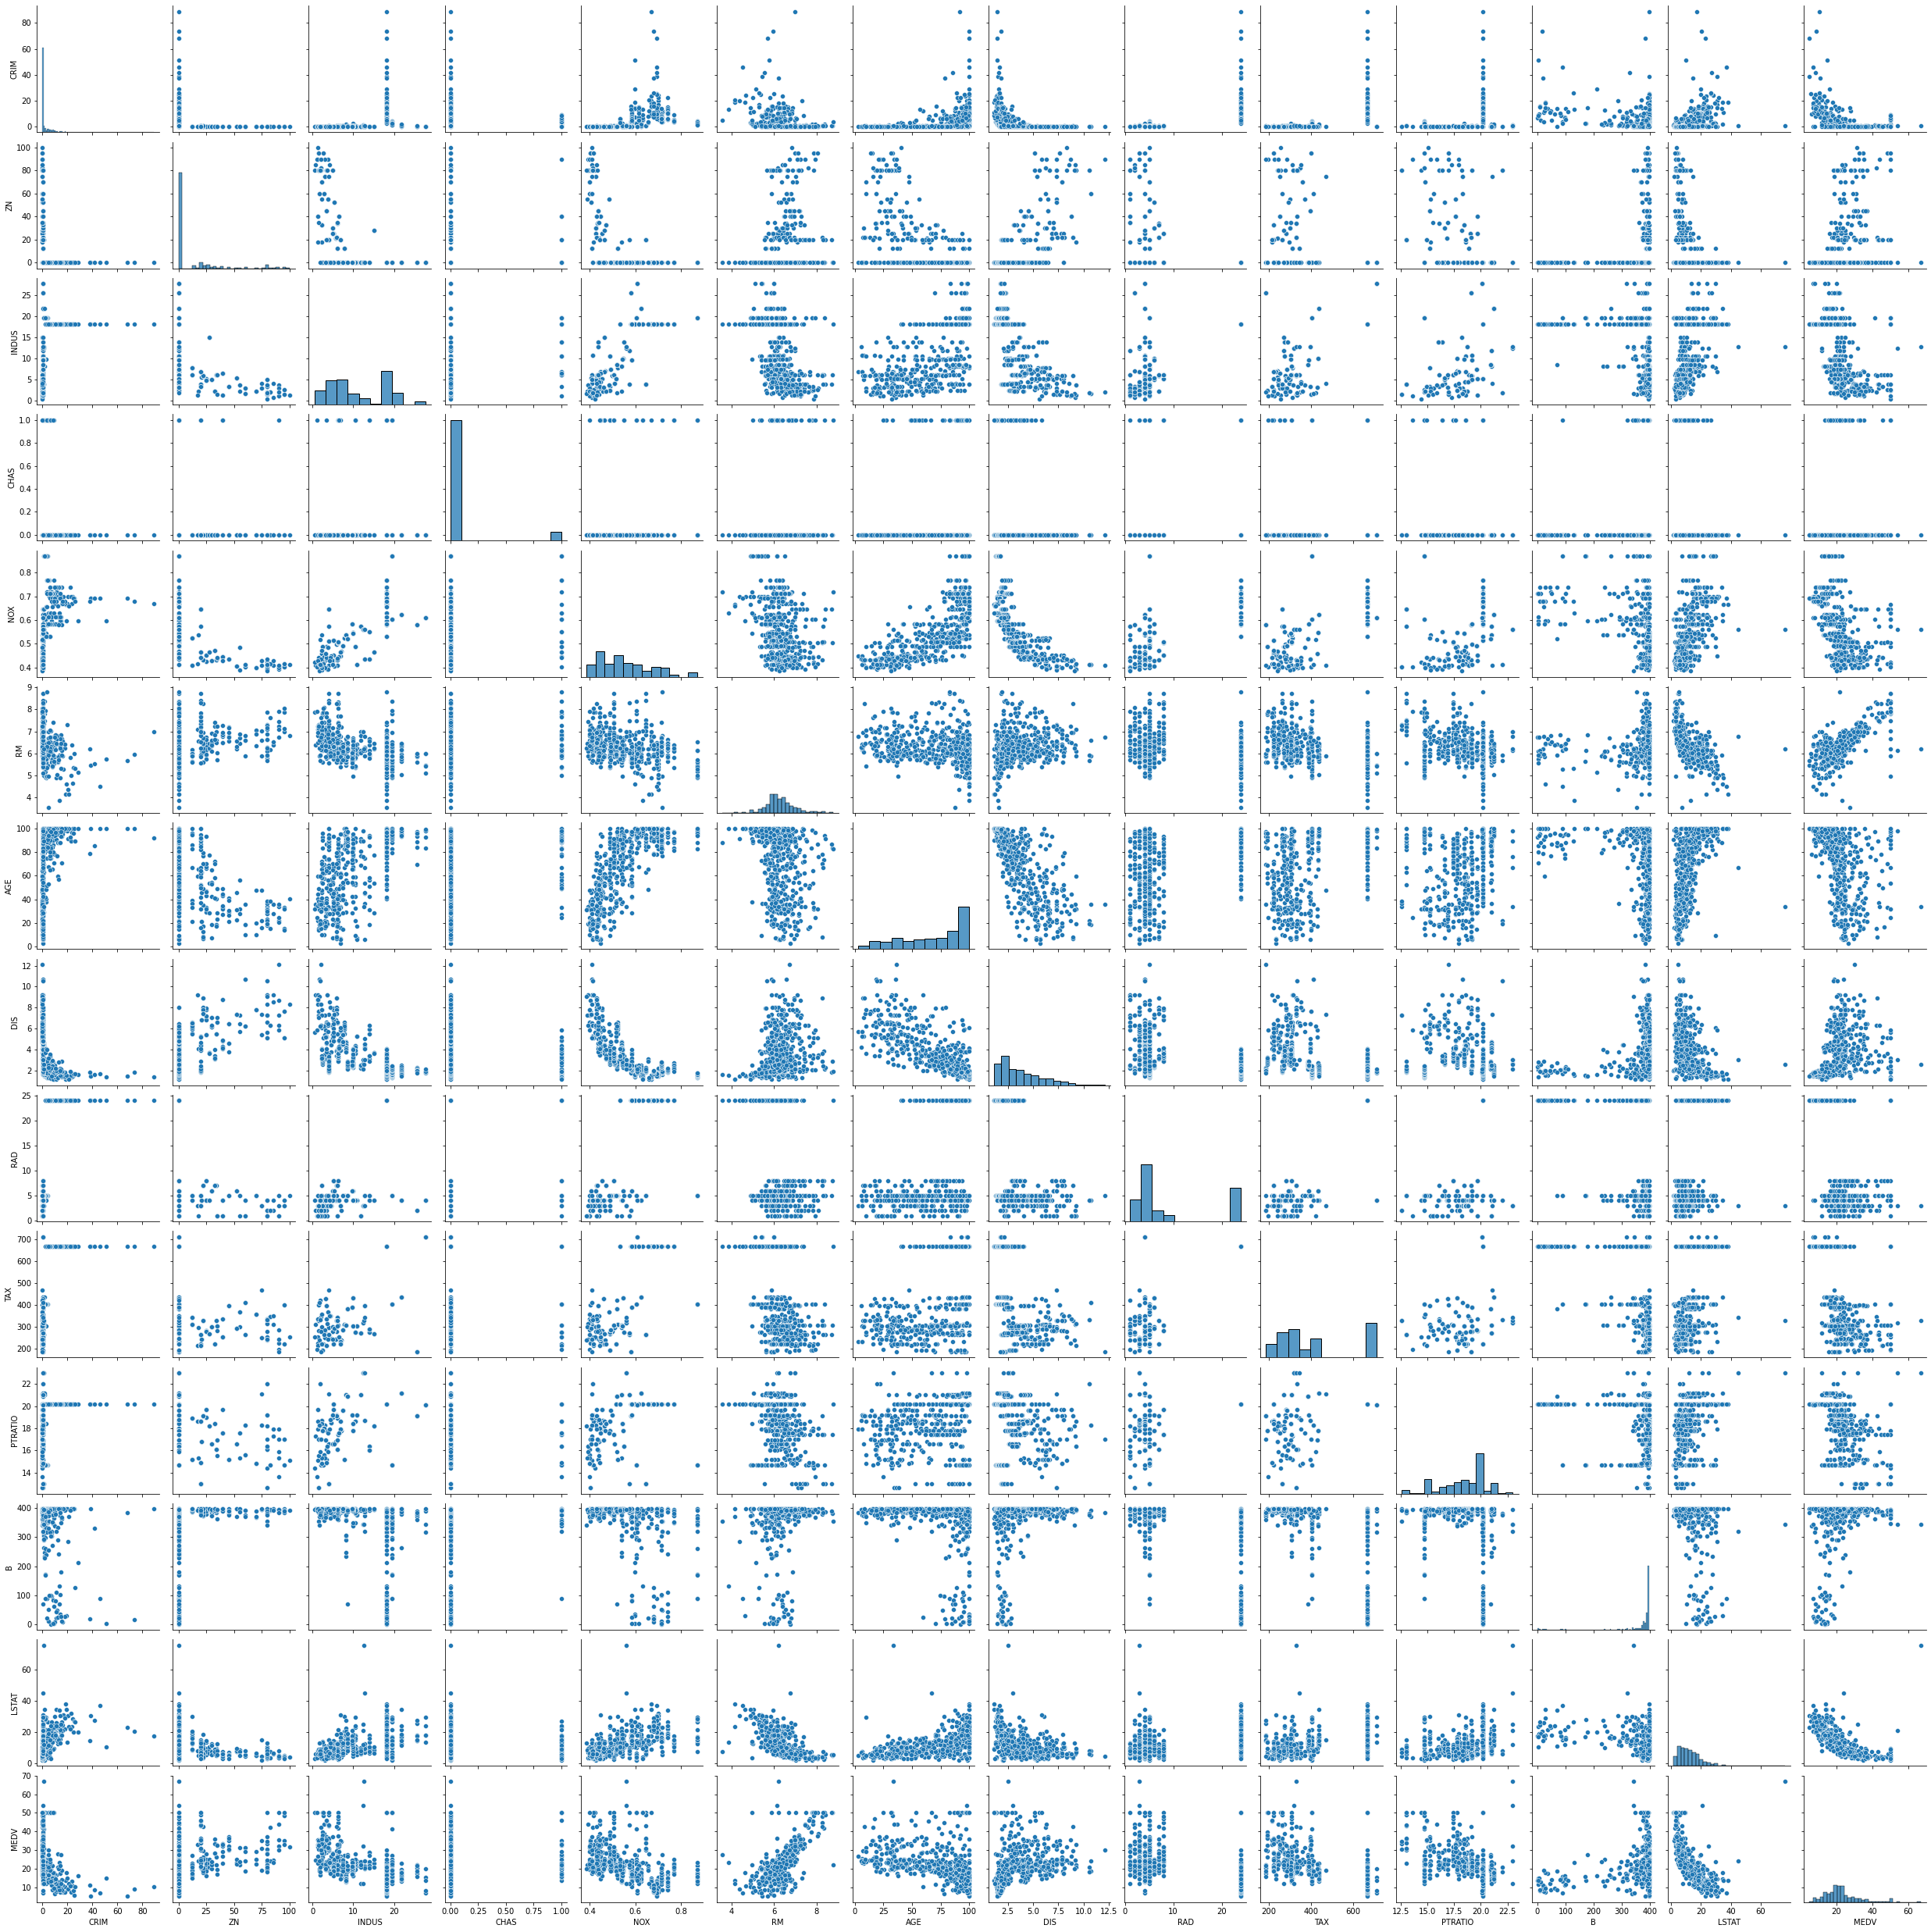

In [7]:
sns.pairplot(data);

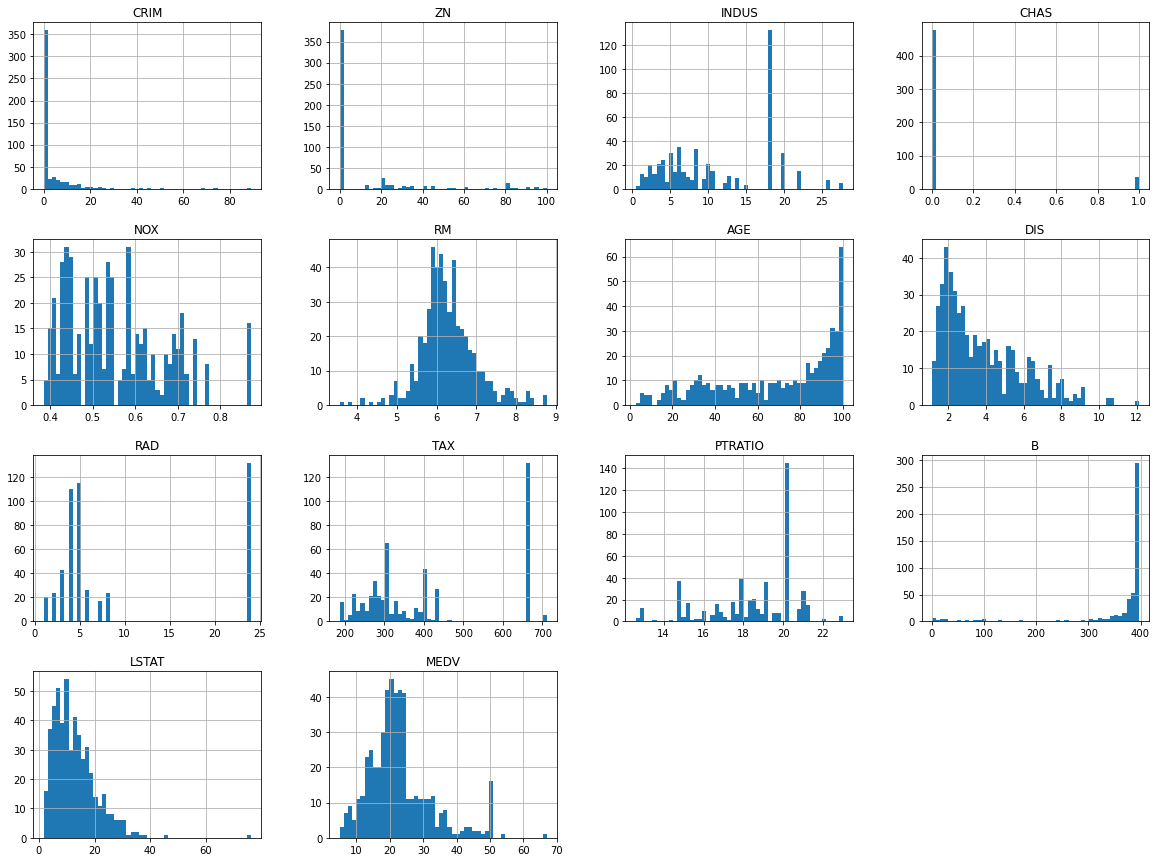

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(20,15))
plt.show()

<AxesSubplot:xlabel='RM', ylabel='MEDV'>

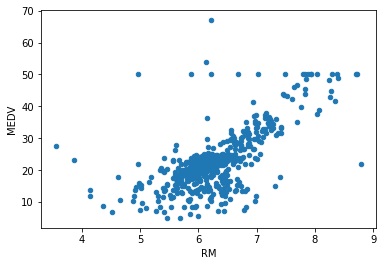

In [9]:
df.plot(kind="scatter",x="RM",y="MEDV")

<AxesSubplot:xlabel='DIS', ylabel='MEDV'>

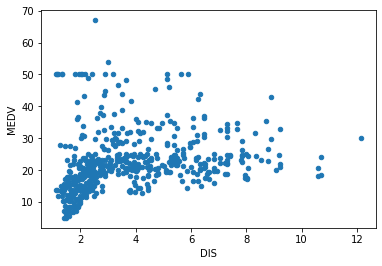

In [10]:
df.plot(kind="scatter",x="DIS",y="MEDV")

<AxesSubplot:xlabel='LSTAT', ylabel='MEDV'>

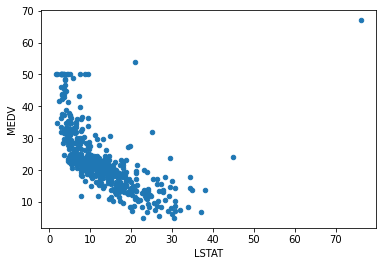

In [11]:
df.plot(kind="scatter",x="LSTAT",y="MEDV")

<AxesSubplot:xlabel='CRIM', ylabel='MEDV'>

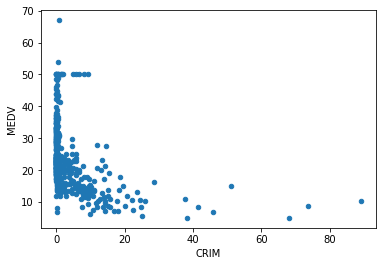

In [12]:
df.plot(kind="scatter",x="CRIM",y="MEDV")

<AxesSubplot:ylabel='Density'>

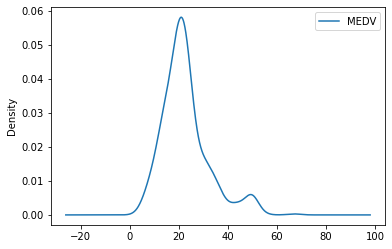

In [13]:
df.plot(kind="kde",x="ZN",y="MEDV")

In [14]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [15]:
display(data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','PTRATIO','MEDV']].groupby(['MEDV']).agg(["max",'mean',"min"]).style.background_gradient(cmap="Oranges"))

CLEANING DATA SET

Text(0.5, 1.0, 'Check Missing Value pada Dataset')

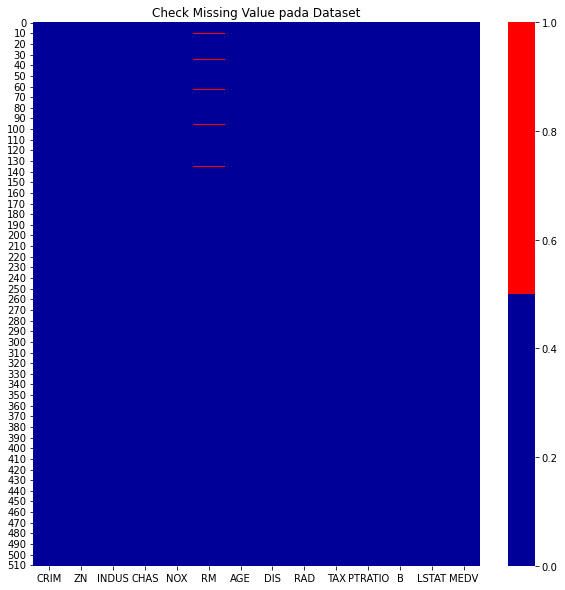

In [16]:
#Representasi Visual Missing Value pada Dataset
# Merah = Data error/hilang, Biru = Data aman
cols = df.columns[:50] 
colours = ['#000099', '#FF0000'] 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours),ax=ax)
plt.title("Check Missing Value pada Dataset")

In [17]:
print('PERSENTASE MISSING VALUE PADA DATASET')
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

PERSENTASE MISSING VALUE PADA DATASET
CRIM - 0%
ZN - 0%
INDUS - 0%
CHAS - 0%
NOX - 0%
RM - 1%
AGE - 0%
DIS - 0%
RAD - 0%
TAX - 0%
PTRATIO - 0%
B - 0%
LSTAT - 0%
MEDV - 0%


In [18]:
df.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  506.000000   
mean     3.584139   11.252446   11.151096    0.068493    0.554757    6.287589   
std      8.564433   23.234838    6.828175    0.252838    0.115310    0.703802   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082325    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.261690    0.000000    9.690000    0.000000    0.538000    6.209000   
75%      3.621175   12.500000   18.100000    0.000000    0.624000    6.629750   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean    68.616243    3.783876    9.485323  407.440313   18.500000  356.600900   
std     28.099130    2.098631    8.688469  167.903532    2.200348   90.882679   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.050000    2.100350    4.000000  279.500000   17.400000  374.710000   
50%     77.300000    3.152300    5.000000  330.000000   19.100000  391.340000   
75%     94.050000    5.118000   24.000000  666.000000   20.200000  396.210000   
max    100.000000   12.126500   24.000000  711.000000   23.000000  396.900000   

            LSTAT        MEDV  
count  511.000000  511.000000  
mean    12.879550   22.682192  
std      7.797416    9.484262  
min      1.730000    5.000000  
25%      7.065000   17.050000  
50%     11.450000   21.200000  
75%     17.105000   25.000000  
max     76.000000   67.000000

In [19]:
print("Null values = \n",data.isnull().sum())
print("")

Null values = 
 CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         5
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64



In [20]:
data = data.fillna(data.mean())
print("Checking null values again = \n",data.isnull().sum())
print("")

Checking null values again = 
 CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64



In [21]:
data.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean     3.584139   11.252446   11.151096    0.068493    0.554757    6.287589   
std      8.564433   23.234838    6.828175    0.252838    0.115310    0.700343   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082325    0.000000    5.190000    0.000000    0.449000    5.887500   
50%      0.261690    0.000000    9.690000    0.000000    0.538000    6.211000   
75%      3.621175   12.500000   18.100000    0.000000    0.624000    6.627000   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean    68.616243    3.783876    9.485323  407.440313   18.500000  356.600900   
std     28.099130    2.098631    8.688469  167.903532    2.200348   90.882679   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.050000    2.100350    4.000000  279.500000   17.400000  374.710000   
50%     77.300000    3.152300    5.000000  330.000000   19.100000  391.340000   
75%     94.050000    5.118000   24.000000  666.000000   20.200000  396.210000   
max    100.000000   12.126500   24.000000  711.000000   23.000000  396.900000   

            LSTAT        MEDV  
count  511.000000  511.000000  
mean    12.879550   22.682192  
std      7.797416    9.484262  
min      1.730000    5.000000  
25%      7.065000   17.050000  
50%     11.450000   21.200000  
75%     17.105000   25.000000  
max     76.000000   67.000000

CLUSTERING THE DATA

In [22]:
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

In [23]:
data_scaled.head()

CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  0.000013  0.035955  0.004614   0.0  0.001075  0.013134  0.130238  0.008170   
1  0.000058  0.000000  0.014961   0.0  0.000992  0.013588  0.166966  0.010511   
2  0.000058  0.000000  0.015133   0.0  0.001004  0.015379  0.130778  0.010632   
3  0.000071  0.000000  0.004772   0.0  0.001003  0.015319  0.100257  0.013270   
4  0.000150  0.000000  0.004740   0.0  0.000996  0.015539  0.117842  0.013181   

        RAD       TAX   PTRATIO         B     LSTAT      MEDV  
0  0.001998  0.591265  0.030562  0.792814  0.009948  0.047940  
1  0.004232  0.512112  0.037668  0.839907  0.019342  0.045709  
2  0.004281  0.517974  0.038099  0.840809  0.008626  0.074272  
3  0.006567  0.485964  0.040935  0.863856  0.006436  0.073114  
4  0.006523  0.482675  0.040658  0.862945  0.011589  0.078707

FIRST A DENDROGRAM WAS IMPLEMENTED

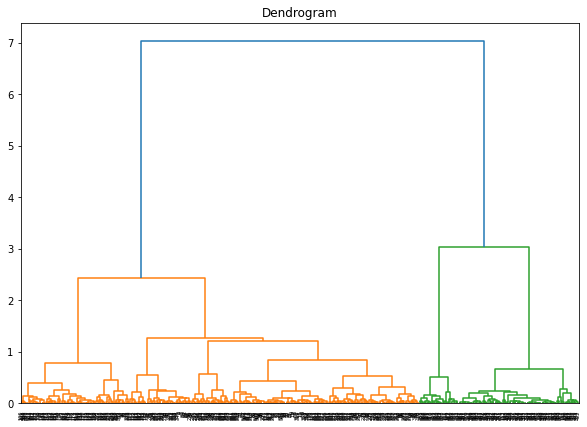

In [24]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

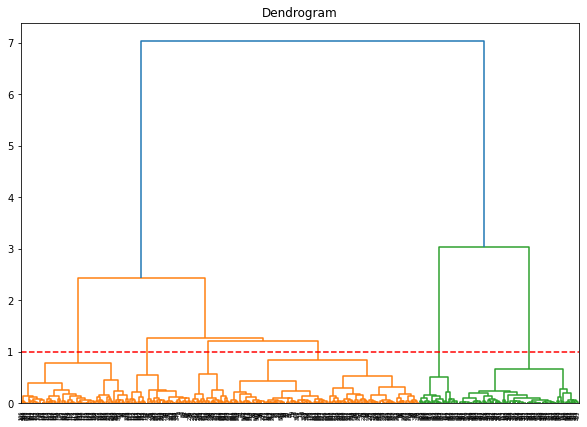

In [25]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1, color='r', linestyle='--')

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [27]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  # potential to use BO to optimize clustering, depending on future results
cluster.fit_predict(data_scaled)

array([0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 4, 4, 4,
       4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 4, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3,
       1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,

Text(0, 0.5, 'MEDV')

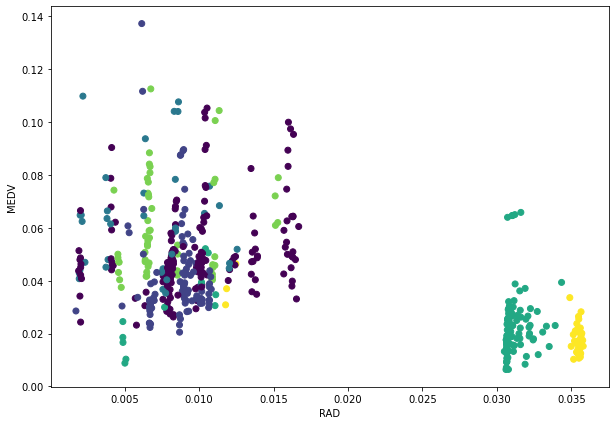

In [28]:
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['RAD'], data_scaled['MEDV'], c=cluster.labels_) 
plt.xlabel('RAD')
plt.ylabel('MEDV')

I have selected 6 different cluster based on the Dendongram, but maybe a better way is to use the Elbow rule to select the number of clusters. So we will use the K-means method to see the shape of the clusters.

K-means CLUSTERING with normalisation

We decided to use 6 clusters form the Dendrogram and to construct the elbow rule and see what could be the best set of clusters

In [29]:
km = KMeans(n_clusters=6)
km.fit(data_scaled)
predictions = km.predict(data_scaled)
labels = km.labels_

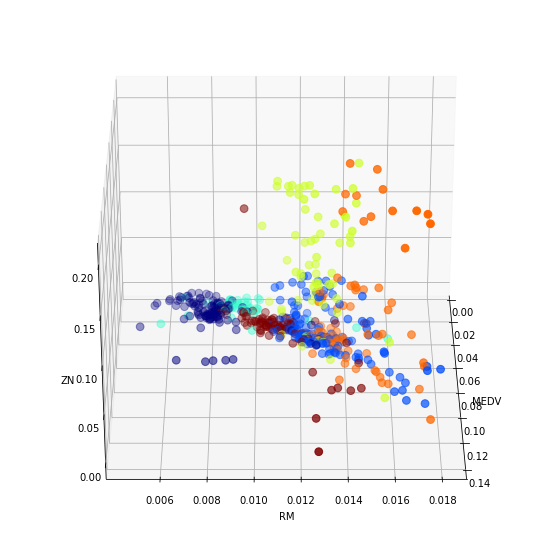

In [30]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(data_scaled['MEDV'])
y = np.array(data_scaled['RM'])
z = np.array(data_scaled['ZN'])

ax.set_xlabel('MEDV')
ax.set_ylabel('RM')
ax.set_zlabel('ZN')

ax.scatter(x,y,z, marker="o", c = predictions, s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

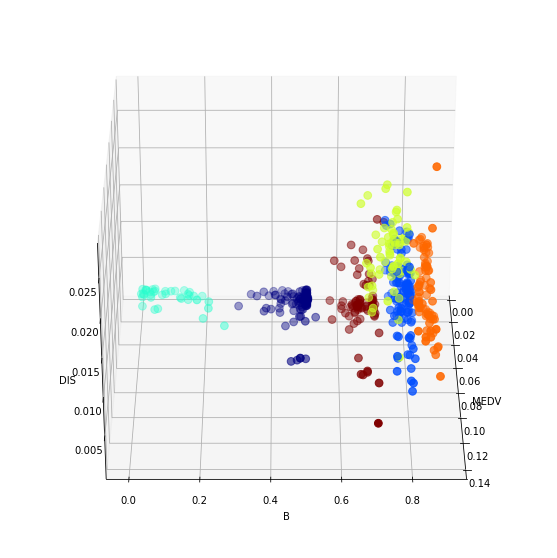

In [31]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(data_scaled['MEDV'])
y = np.array(data_scaled['B'])
z = np.array(data_scaled['DIS'])

ax.set_xlabel('MEDV')
ax.set_ylabel('B')
ax.set_zlabel('DIS')

ax.scatter(x,y,z, marker="o", c = predictions, s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

USING THE ELBOW RULE

In [32]:
N = range(1, 20)
kmeans = []
for i in N:
    kmeans.append(KMeans(i))

In [33]:
score = []
for i in range(len(kmeans)):
    score.append(kmeans[i].fit(data_scaled).score(data_scaled))

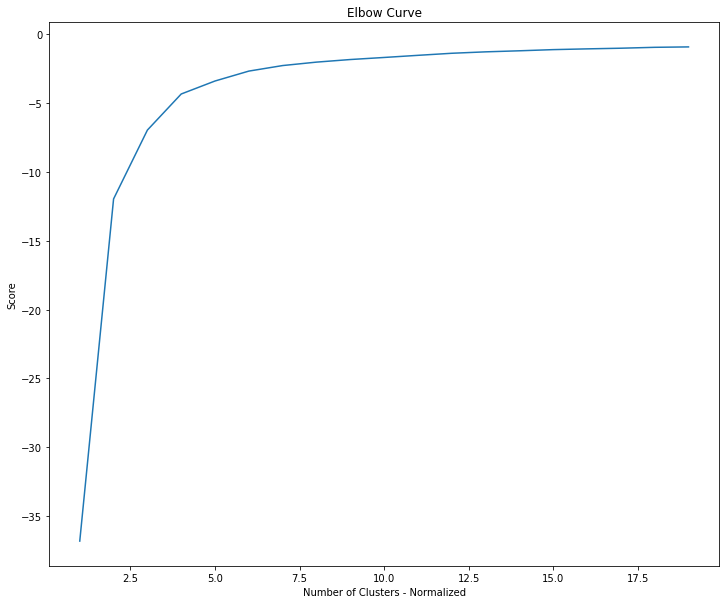

In [34]:
fig = plt.figure(figsize=(12,10))
pl.plot(N,score)
pl.xlabel('Number of Clusters - Normalized')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show() 
fig.savefig('Elbow Curve')

According to the Elbow rule the selected number of clusters should be 3

In [35]:
km = KMeans(n_clusters=3)
km.fit(data_scaled)
predictions = km.predict(data_scaled)
labels = km.labels_

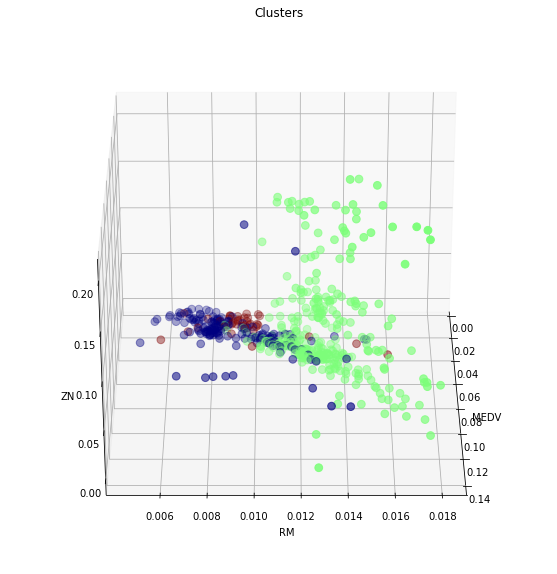

In [36]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(data_scaled['MEDV'])
y = np.array(data_scaled['RM'])
z = np.array(data_scaled['ZN'])

ax.set_xlabel('MEDV')
ax.set_ylabel('RM')
ax.set_zlabel('ZN')
plt.title("Clusters")

ax.scatter(x,y,z, marker="o", c = predictions, s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()
fig.savefig('Clusters')

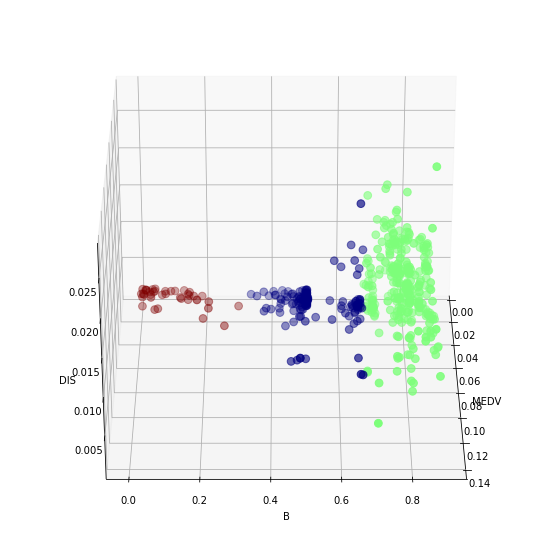

In [37]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(data_scaled['MEDV'])
y = np.array(data_scaled['B'])
z = np.array(data_scaled['DIS'])

ax.set_xlabel('MEDV')
ax.set_ylabel('B')
ax.set_zlabel('DIS')

ax.scatter(x,y,z, marker="o", c = predictions, s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

It seems with 3 cluster the data are more compact. The Elbow rule help to group the data to maximize the information that we can extract. With this number of cluster we will prepare a set of datas, that would enable us to fit Ensemble Random Forest Regressor and find the feature that are most relevant to predict the value. The main purpose it is not to predict the value per se, but rather to identify the most relevant features that could help the product design department to desing real estate products that maximize the value of property. The intention is to define a set of feature for the products targeting the 3 different cluster of product in a way that it maximizes the MEDV value. Therefore we will create the data subset for each of the Cluster 0, 1 and 3, that we would compare with the entire data set. 

CREATION OF THE DATA SETS TO BE USED: data (all data), data_0 (cluster 0), data_1, data_2

In [38]:
data['Clusters_norm'] = predictions

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           511 non-null    float64
 1   ZN             511 non-null    float64
 2   INDUS          511 non-null    float64
 3   CHAS           511 non-null    int64  
 4   NOX            511 non-null    float64
 5   RM             511 non-null    float64
 6   AGE            511 non-null    float64
 7   DIS            511 non-null    float64
 8   RAD            511 non-null    int64  
 9   TAX            511 non-null    int64  
 10  PTRATIO        511 non-null    float64
 11  B              511 non-null    float64
 12  LSTAT          511 non-null    float64
 13  MEDV           511 non-null    float64
 14  Clusters_norm  511 non-null    int32  
dtypes: float64(11), int32(1), int64(3)
memory usage: 58.0 KB


In [40]:
condition_cluster_0 = data['Clusters_norm'] == 0
condition_cluster_1 = data['Clusters_norm'] == 1
condition_cluster_2 = data['Clusters_norm'] == 2
data_0 = data.loc[condition_cluster_0]
data_1 = data.loc[condition_cluster_1]
data_2 = data.loc[condition_cluster_2]

In [41]:
data_0.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
32   1.38799   0.0   8.14     0  0.538  5.950  82.0  3.9900    4  307   
34   1.61282   0.0   8.14     0  0.538  6.096  96.9  3.7598    4  307   
54   0.01360  75.0   4.00     0  0.410  5.888  47.6  7.3197    3  469   
111  0.10084   0.0  10.01     0  0.547  6.715  81.6  2.6775    6  432   
112  0.12329   0.0  10.01     0  0.547  5.913  92.9  2.3534    6  432   

     PTRATIO       B  LSTAT  MEDV  Clusters_norm  
32      21.0  232.60  27.71  13.2              0  
34      21.0  248.31  20.34  13.5              0  
54      21.1  396.90  14.80  18.9              0  
111     17.8  395.59  10.16  22.8              0  
112     17.8  394.95  16.21  18.8              0

In [42]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 32 to 510
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           156 non-null    float64
 1   ZN             156 non-null    float64
 2   INDUS          156 non-null    float64
 3   CHAS           156 non-null    int64  
 4   NOX            156 non-null    float64
 5   RM             156 non-null    float64
 6   AGE            156 non-null    float64
 7   DIS            156 non-null    float64
 8   RAD            156 non-null    int64  
 9   TAX            156 non-null    int64  
 10  PTRATIO        156 non-null    float64
 11  B              156 non-null    float64
 12  LSTAT          156 non-null    float64
 13  MEDV           156 non-null    float64
 14  Clusters_norm  156 non-null    int32  
dtypes: float64(11), int32(1), int64(3)
memory usage: 18.9 KB


In [43]:
data_1.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  Clusters_norm  
0  396.90   4.98  24.0              1  
1  396.90   9.14  21.6              1  
2  392.83   4.03  34.7              1  
3  394.63   2.94  33.4              1  
4  396.90   5.33  36.2              1

In [44]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 509
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           317 non-null    float64
 1   ZN             317 non-null    float64
 2   INDUS          317 non-null    float64
 3   CHAS           317 non-null    int64  
 4   NOX            317 non-null    float64
 5   RM             317 non-null    float64
 6   AGE            317 non-null    float64
 7   DIS            317 non-null    float64
 8   RAD            317 non-null    int64  
 9   TAX            317 non-null    int64  
 10  PTRATIO        317 non-null    float64
 11  B              317 non-null    float64
 12  LSTAT          317 non-null    float64
 13  MEDV           317 non-null    float64
 14  Clusters_norm  317 non-null    int32  
dtypes: float64(11), int32(1), int64(3)
memory usage: 38.4 KB


In [45]:
data_2.head()

CRIM   ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
102   0.22876  0.0   8.56     0  0.520  6.405   85.4  2.7147    5  384   
155   3.53501  0.0  19.58     1  0.871  6.152   82.6  1.7455    5  403   
156   2.44668  0.0  19.58     0  0.871  5.272   94.0  1.7364    5  403   
367  13.52220  0.0  18.10     0  0.631  3.863  100.0  1.5106   24  666   
409  14.43830  0.0  18.10     0  0.597  6.852  100.0  1.4655   24  666   

     PTRATIO       B  LSTAT  MEDV  Clusters_norm  
102     20.9   70.80  10.63  18.6              2  
155     14.7   88.01  15.02  15.6              2  
156     14.7   88.63  16.14  13.1              2  
367     20.2  131.42  13.33  23.1              2  
409     20.2  179.36  19.78  27.5              2

In [46]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 102 to 466
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CRIM           38 non-null     float64
 1   ZN             38 non-null     float64
 2   INDUS          38 non-null     float64
 3   CHAS           38 non-null     int64  
 4   NOX            38 non-null     float64
 5   RM             38 non-null     float64
 6   AGE            38 non-null     float64
 7   DIS            38 non-null     float64
 8   RAD            38 non-null     int64  
 9   TAX            38 non-null     int64  
 10  PTRATIO        38 non-null     float64
 11  B              38 non-null     float64
 12  LSTAT          38 non-null     float64
 13  MEDV           38 non-null     float64
 14  Clusters_norm  38 non-null     int32  
dtypes: float64(11), int32(1), int64(3)
memory usage: 4.6 KB


In [47]:
data_0.drop(columns=['Clusters_norm'], axis = 1, inplace = True) #execute just one time per run of the notebook

In [48]:
data_1.drop(columns=['Clusters_norm'], axis = 1, inplace = True) #execute just one time per run of the notebook

In [49]:
data_2.drop(columns=['Clusters_norm'], axis = 1, inplace = True) #execute just one time per run of the notebook

In [50]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  Clusters_norm  
0  396.90   4.98  24.0              1  
1  396.90   9.14  21.6              1  
2  392.83   4.03  34.7              1  
3  394.63   2.94  33.4              1  
4  396.90   5.33  36.2              1

UNDERSTANDING OF THE CLUSTERS 

In [51]:
display(data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','PTRATIO','MEDV','Clusters_norm']].groupby(['Clusters_norm']).agg(["max",'mean',"min"]).style.background_gradient(cmap="Oranges"))

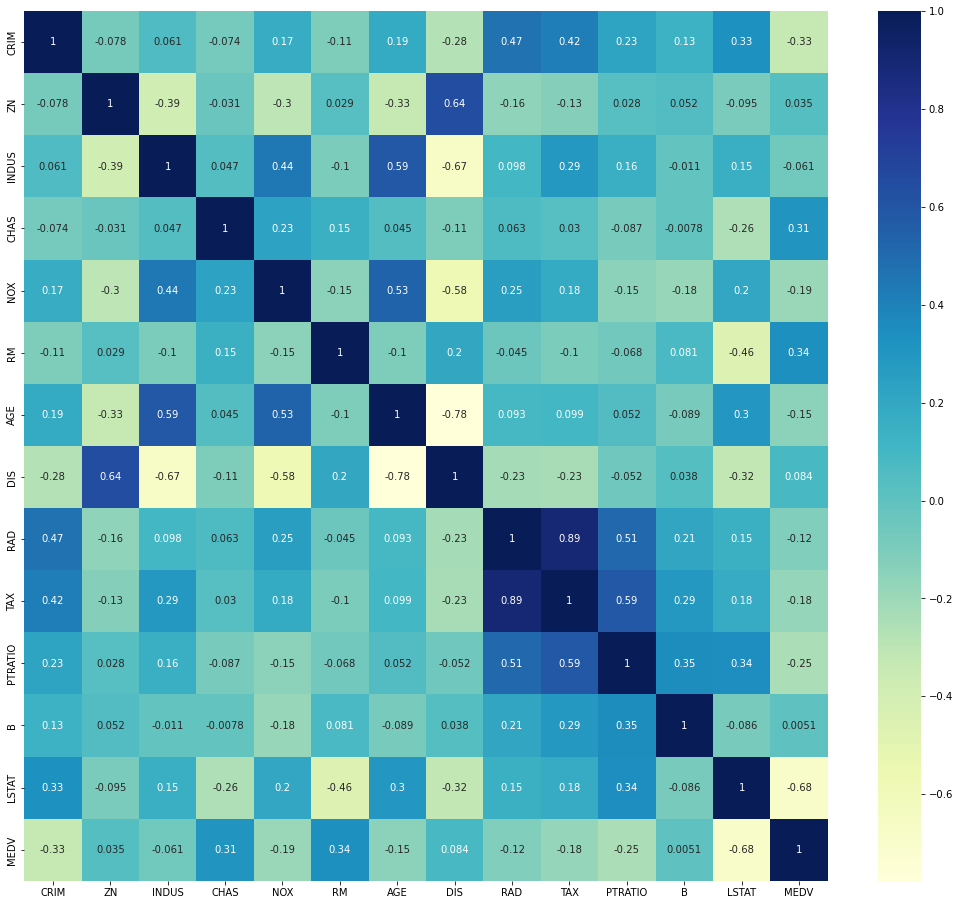

In [52]:
plt.figure(figsize=(18,16))
cor = data_0.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlGnBu)
plt.show()

In [53]:
corr_matrix = data_0.corr()
corr_matrix['MEDV'].sort_values(ascending=True)

LSTAT     -0.680178
CRIM      -0.331678
PTRATIO   -0.248183
NOX       -0.193707
TAX       -0.179672
AGE       -0.149313
RAD       -0.115774
INDUS     -0.060850
B          0.005114
ZN         0.035396
DIS        0.084046
CHAS       0.307988
RM         0.336061
MEDV       1.000000
Name: MEDV, dtype: float64

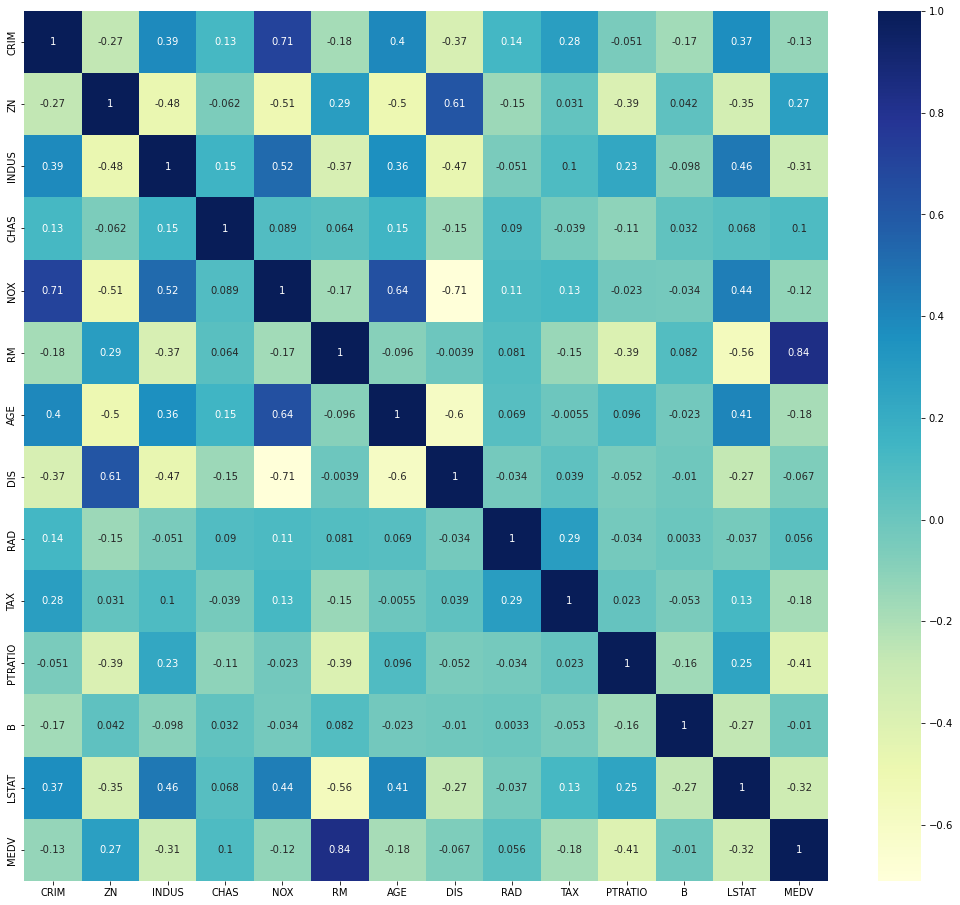

In [54]:
plt.figure(figsize=(18,16))
cor = data_1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlGnBu)
plt.show()

In [55]:
corr_matrix = data_1.corr()
corr_matrix['MEDV'].sort_values(ascending=True)

PTRATIO   -0.405603
LSTAT     -0.318595
INDUS     -0.309139
AGE       -0.183251
TAX       -0.176019
CRIM      -0.130681
NOX       -0.124470
DIS       -0.066747
B         -0.009952
RAD        0.056483
CHAS       0.103806
ZN         0.273888
RM         0.835874
MEDV       1.000000
Name: MEDV, dtype: float64

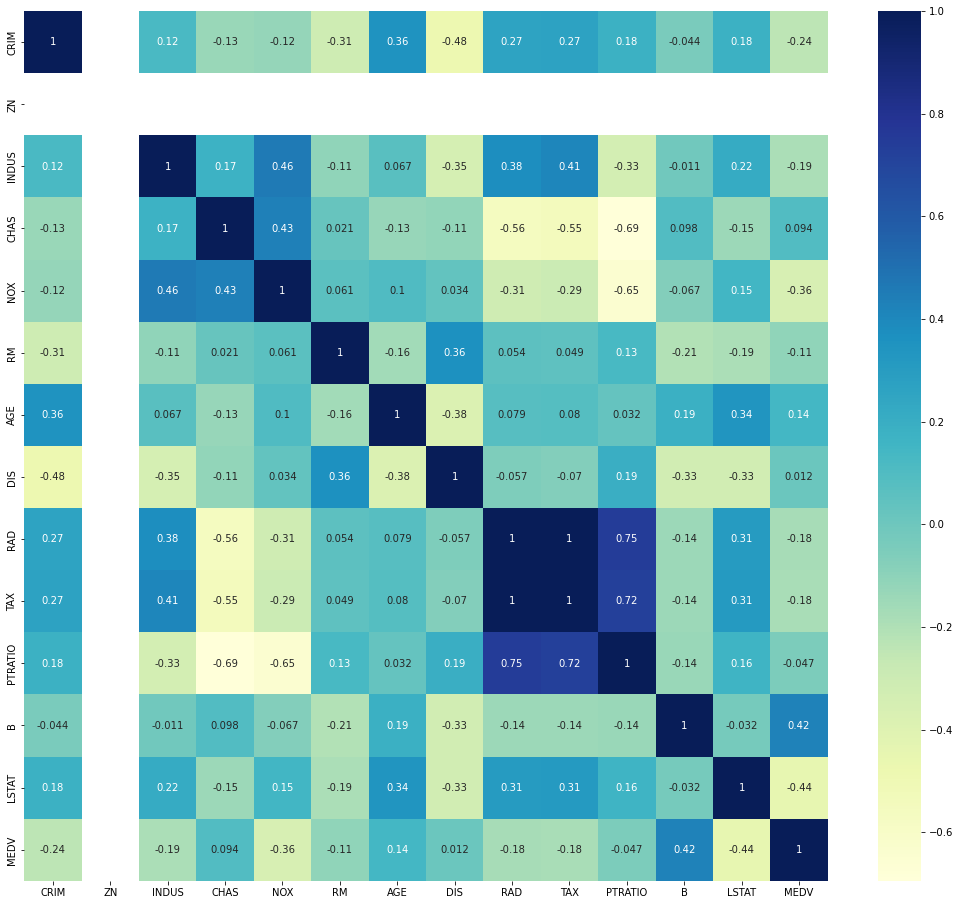

In [56]:
plt.figure(figsize=(18,16))
cor = data_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlGnBu)
plt.show()

In [57]:
corr_matrix = data_2.corr()
corr_matrix['MEDV'].sort_values(ascending=True)

LSTAT     -0.444687
NOX       -0.362397
CRIM      -0.243785
INDUS     -0.187228
TAX       -0.182622
RAD       -0.178234
RM        -0.106442
PTRATIO   -0.047210
DIS        0.011586
CHAS       0.093766
AGE        0.140022
B          0.424629
MEDV       1.000000
ZN              NaN
Name: MEDV, dtype: float64

Now that we organized the data in 3 different cluster, the idea is to do a prediction of the value MEDV in each of the clusters to see if the different features impacts in different ways the value.

ANALISYS OF THE ENTIRE DATASET

In [58]:
data.drop(columns=['Clusters_norm'], axis = 1, inplace = True) #execute just one time per run of the notebook

In [59]:
Xy=np.array(data)

In [60]:
seed = np.random.seed(10)
np.random.shuffle(Xy)

In [61]:
X=Xy[:,:-1]
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split `X` into training, validation and test sets.

In [62]:
trainsize = int(len(data)/2)
trainplusvalsize = int(len(data)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

Random Forest fit for all data

Grid search for best parameters

In [63]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_estimators'      : [100, 200, 300],
                  'criterion'         : ['squared_error', 
                                         'absolute_error',
                                         'poisson'],
                  'max_features'      : ['sqrt', 
                                         'log2', 
                                          None]  
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator  = ensemble.RandomForestRegressor(),
                    param_grid = hp_candidates, 
                    scoring    = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 300}


In [64]:
# Create Random Forrest regressor based on grid search

eRFR = ensemble.RandomForestRegressor(n_estimators = params['n_estimators'],
                                        criterion    = params['criterion'],
                                        max_features = params['max_features'])
                     
eRFR.fit(X_train, y_train)

# Test accuracy

y_pred = eRFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Eclassifier accuracy on test set:    ',acc,'%')

Eclassifier accuracy on test set:     86.9 %


Feature Selection

In [65]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

eRFR.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',eRFR.score(X_trainval, y_trainval),eRFR.score(X_test, y_test))

Full tree guess train/validation  0.957263880690964 0.6597809917380684


In [66]:
feature_importances = eRFR.feature_importances_
sorted_idx = feature_importances.argsort()

In [67]:
feature_names = df.columns[:-1]

In [68]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

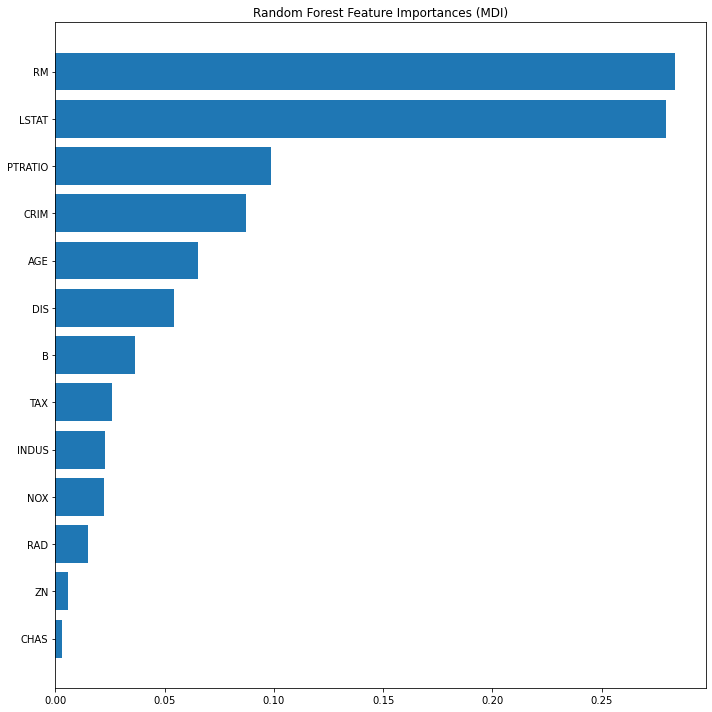

In [69]:
# impurity metric based approach on training

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

USING SHAP VALUES TO EXPLAIN THE IMPACT IN VALUE FROM THE FEATURES

In [70]:
data_X_train = pd.DataFrame(X_train, columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

In [71]:
# using the Shap tree explainer for faster computation
explainer = shap.TreeExplainer(eRFR)

# generating the shape values
shap_values = explainer.shap_values(data_X_train)

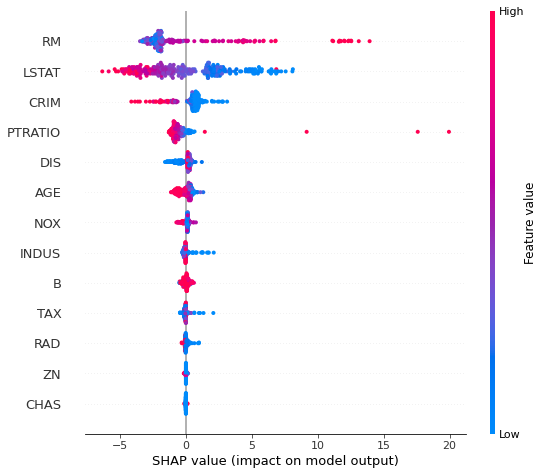

In [72]:
fig = plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, data_X_train)
fig.savefig('Shap values All data')

In [73]:
data_X_train.iloc[[0]]

CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0  2.63548  0.0    9.9   0.0  0.544  4.973  37.8  2.5194  4.0  304.0     18.4   

        B  LSTAT  
0  350.45  12.64

In [74]:
# visualize the first prediction's explanation 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data_X_train.iloc[[0]])


NOW CLUSTER 0 will be analysed

In [75]:
Xy=np.array(data_0)

In [76]:
seed = np.random.seed(10)
np.random.shuffle(Xy)

In [77]:
X=Xy[:,:-1]
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split X into training, validation and test sets

In [78]:
trainsize = int(len(data_0)/2)
trainplusvalsize = int(len(data_0)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

Random Forest fit

Grid search for best parameters

In [79]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_estimators'      : [100, 200, 300],
                  'criterion'         : ['squared_error', 
                                         'absolute_error',
                                         'poisson'],
                  'max_features'      : ['sqrt', 
                                         'log2', 
                                          None]  
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator  = ensemble.RandomForestRegressor(),
                    param_grid = hp_candidates, 
                    scoring    = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 100}


In [80]:
# Create Random Forrest regressor based on grid search

eRFR = ensemble.RandomForestRegressor(n_estimators = params['n_estimators'],
                                        criterion    = params['criterion'],
                                        max_features = params['max_features'])
                     
eRFR.fit(X_train, y_train)

# Test accuracy

y_pred = eRFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Eclassifier accuracy on test set:    ',acc,'%')

Eclassifier accuracy on test set:     85.3 %


Feature selection

In [81]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

eRFR.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',eRFR.score(X_trainval, y_trainval),eRFR.score(X_test, y_test))

Full tree guess train/validation  0.9457190655541391 0.7460758060909709


In [82]:
feature_importances = eRFR.feature_importances_
sorted_idx = feature_importances.argsort()

In [83]:
feature_names = df.columns[:-1]

In [84]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

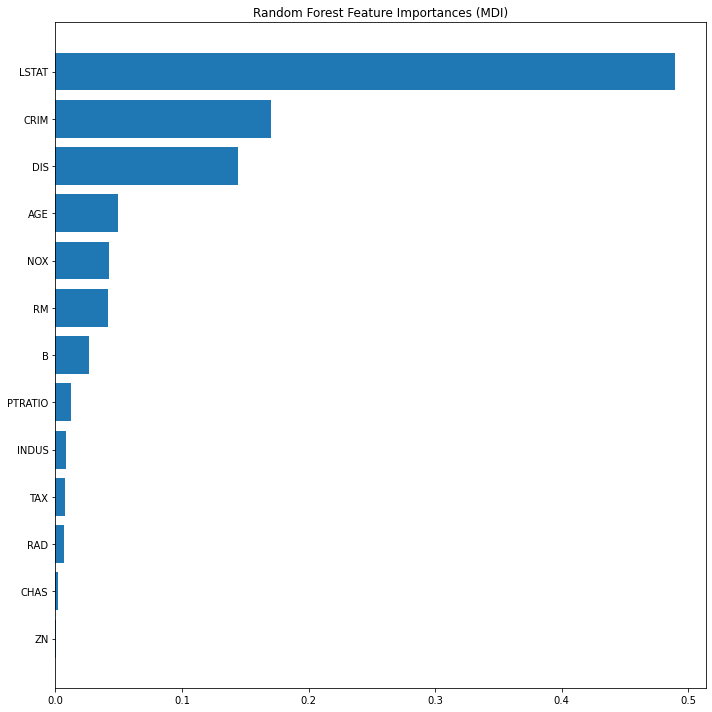

In [85]:
# impurity metric based approach on training

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

USING SHAP VALUES TO EXPLAIN THE IMPACT IN VALUE FROM THE FEATURES

In [86]:
data_0_X_train = pd.DataFrame(X_train, columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

In [87]:
# using the Shap tree explainer for faster computation
explainer = shap.TreeExplainer(eRFR)

# generating the shape values
shap_values = explainer.shap_values(data_0_X_train)

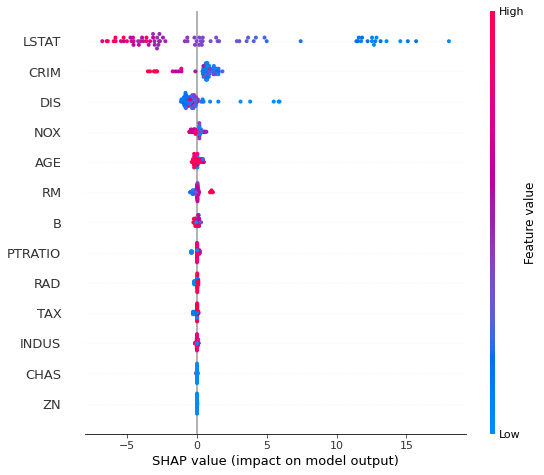

In [88]:
fig = plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, data_0_X_train)
fig.savefig('Shap values Cluster 0')

In [89]:
data_0_X_train.iloc[[0]]

CRIM   ZN  INDUS  CHAS  NOX     RM   AGE     DIS   RAD    TAX  PTRATIO  \
0  16.8118  0.0   18.1   0.0  0.7  5.277  98.1  1.4261  24.0  666.0     20.2   

       B  LSTAT  
0  396.9  30.81

In [90]:
# visualize the first prediction's explanation 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data_0_X_train.iloc[[0]])


NOW CLUSTER 1 will be analysed

In [91]:
data_1.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [92]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 509
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     317 non-null    float64
 1   ZN       317 non-null    float64
 2   INDUS    317 non-null    float64
 3   CHAS     317 non-null    int64  
 4   NOX      317 non-null    float64
 5   RM       317 non-null    float64
 6   AGE      317 non-null    float64
 7   DIS      317 non-null    float64
 8   RAD      317 non-null    int64  
 9   TAX      317 non-null    int64  
 10  PTRATIO  317 non-null    float64
 11  B        317 non-null    float64
 12  LSTAT    317 non-null    float64
 13  MEDV     317 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 37.1 KB


In [93]:
Xy=np.array(data_1)

In [94]:
seed = np.random.seed(10)
np.random.shuffle(Xy)

In [95]:
X=Xy[:,:-1]
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split X into training, validation and test sets

In [96]:
trainsize = int(len(data_1)/2)
trainplusvalsize = int(len(data_1)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

Random Forest fit

In [97]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_estimators'      : [100, 200, 300],
                  'criterion'         : ['squared_error', 
                                         'absolute_error',
                                         'poisson'],
                  'max_features'      : ['sqrt', 
                                         'log2', 
                                          None]  
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator  = ensemble.RandomForestRegressor(),
                    param_grid = hp_candidates, 
                    scoring    = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'criterion': 'squared_error', 'max_features': None, 'n_estimators': 100}


In [98]:
# Create Random Forrest regressor based on grid search

eRFR = ensemble.RandomForestRegressor(n_estimators = params['n_estimators'],
                                        criterion    = params['criterion'],
                                        max_features = params['max_features'])
                     
eRFR.fit(X_train, y_train)

# Test accuracy

y_pred = eRFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Eclassifier accuracy on test set:    ',acc,'%')

Eclassifier accuracy on test set:     91.1 %


Feature selection

In [99]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

eRFR.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',eRFR.score(X_trainval, y_trainval),eRFR.score(X_test, y_test))

Full tree guess train/validation  0.9213119943668912 0.8757537383543923


In [100]:
feature_importances = eRFR.feature_importances_
sorted_idx = feature_importances.argsort()

In [101]:
feature_names = df.columns[:-1]

In [102]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

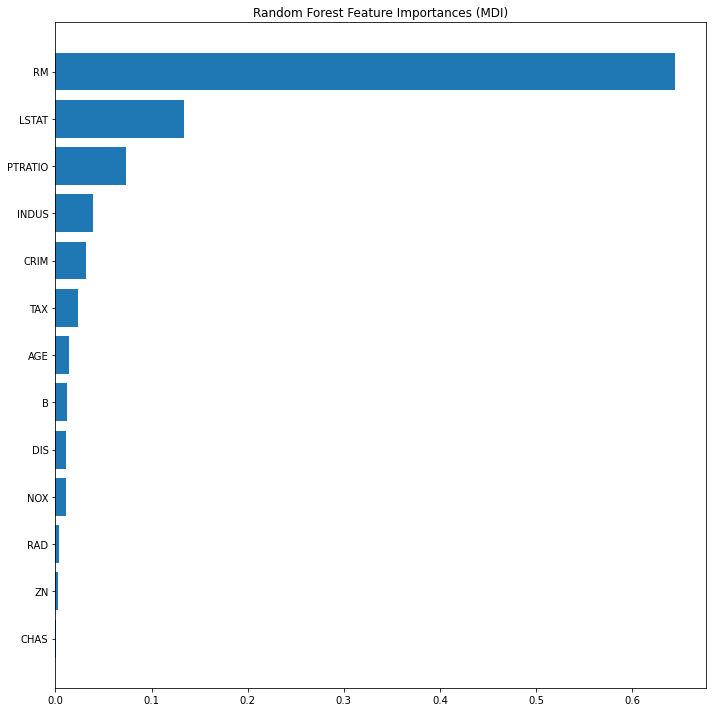

In [103]:
# impurity metric based approach on training

plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

USING SHAP VALUES TO EXPLAIN THE IMPACT IN VALUE FROM THE FEATURES

In [104]:
data_1_X_train = pd.DataFrame(X_train, columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

In [105]:
# using the Shap tree explainer for faster computation
explainer = shap.TreeExplainer(eRFR)

# generating the shape values
shap_values = explainer.shap_values(data_1_X_train)

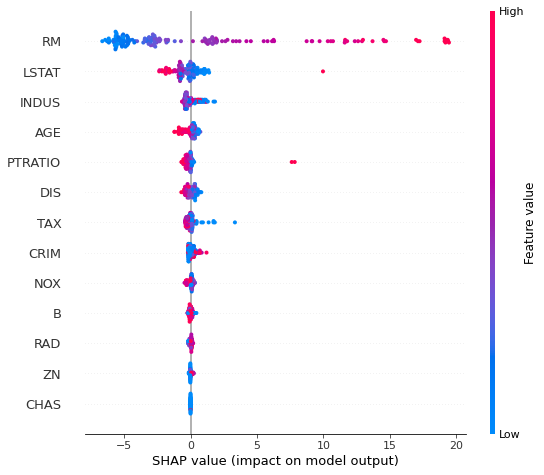

In [106]:
fig = plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, data_1_X_train)
fig.savefig('Shap values Cluster 1')

In [107]:
data_1_X_train.iloc[[0]]

CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0  0.10959  0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0     21.0   

        B  LSTAT  
0  393.45   6.48

In [108]:
# visualize the first prediction's explanation 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data_1_X_train.iloc[[0]])


NOW CLUSTER 2 will be analysed

In [109]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 102 to 466
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     38 non-null     float64
 1   ZN       38 non-null     float64
 2   INDUS    38 non-null     float64
 3   CHAS     38 non-null     int64  
 4   NOX      38 non-null     float64
 5   RM       38 non-null     float64
 6   AGE      38 non-null     float64
 7   DIS      38 non-null     float64
 8   RAD      38 non-null     int64  
 9   TAX      38 non-null     int64  
 10  PTRATIO  38 non-null     float64
 11  B        38 non-null     float64
 12  LSTAT    38 non-null     float64
 13  MEDV     38 non-null     float64
dtypes: float64(11), int64(3)
memory usage: 4.5 KB


In [110]:
Xy=np.array(data_2)

In [111]:
seed = np.random.seed(10)
np.random.shuffle(Xy)

In [112]:
X=Xy[:,:-1]
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split X into training, validation and test sets

In [113]:
trainsize = int(len(data_2)/2)
trainplusvalsize = int(len(data_2)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

Random Forest fit

Grid search

In [114]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_estimators'      : [100, 200, 300],
                  'criterion'         : ['squared_error', 
                                         'absolute_error',
                                         'poisson'],
                  'max_features'      : ['sqrt', 
                                         'log2', 
                                          None]  
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator  = ensemble.RandomForestRegressor(),
                    param_grid = hp_candidates, 
                    scoring    = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 200}


In [115]:
# Create Random Forrest regressor based on grid search

eRFR = ensemble.RandomForestRegressor(n_estimators = params['n_estimators'],
                                        criterion    = params['criterion'],
                                        max_features = params['max_features'])
                     
eRFR.fit(X_train, y_train)

# Test accuracy

y_pred = eRFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Eclassifier accuracy on test set:    ',acc,'%')

Eclassifier accuracy on test set:     76.7 %


Feature selection

In [116]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

eRFR.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',eRFR.score(X_trainval, y_trainval),eRFR.score(X_test, y_test))

Full tree guess train/validation  0.8657964978635854 -0.22220495681842745


In [117]:
feature_importances = eRFR.feature_importances_
sorted_idx = feature_importances.argsort()

In [118]:
feature_names = df.columns[:-1]

In [119]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

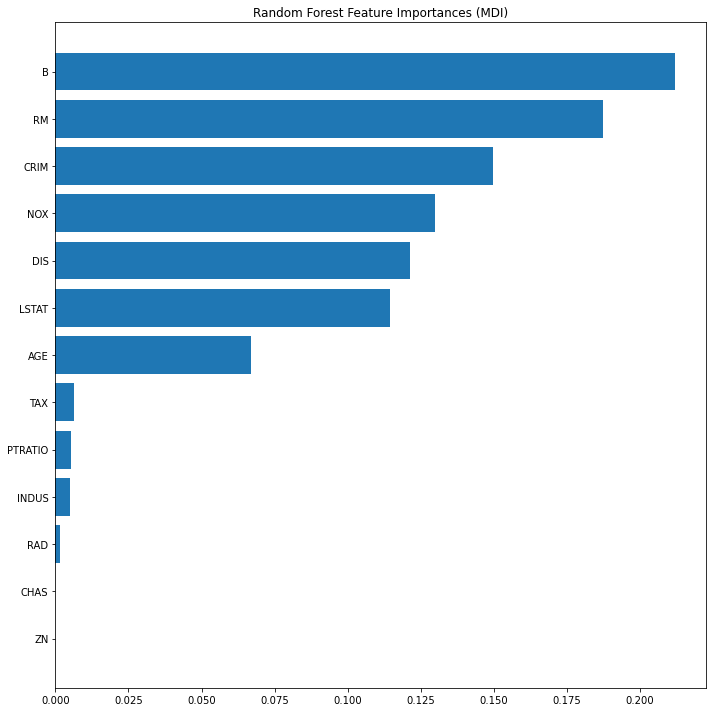

In [120]:
# impurity metric based approach on training
plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

USING SHAP VALUES TO EXPLAIN THE IMPACT IN VALUE FROM THE FEATURES

In [121]:
data_2_X_train = pd.DataFrame(X_train, columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

In [122]:
# using the Shap tree explainer for faster computation
explainer = shap.TreeExplainer(eRFR)

# generating the shape values
shap_values = explainer.shap_values(data_2_X_train)

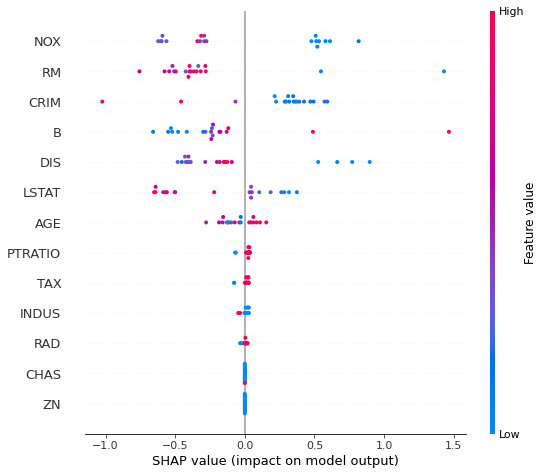

In [123]:
fig = plt.figure(figsize=(12,10))
shap.summary_plot(shap_values, data_2_X_train)
fig.savefig('Shap values Cluster 2')

In [124]:
 data_2_X_train.iloc[[0]]

CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
0  6.44405  0.0   18.1   0.0  0.584  6.425  74.8  2.2004  24.0  666.0   

   PTRATIO      B  LSTAT  
0     20.2  97.95  12.03

In [125]:
# visualize the first prediction's explanation 

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data_2_X_train.iloc[[0]])
